In [1]:
import numpy as np 
import pandas as pd

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
%matplotlib inline

# time series related 
from pmdarima import auto_arima#automatically determine the best-fitting ARIMA (Autoregressive Integrated Moving Average) 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults

# handle warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [ ]:
#!pip install pmdarima

In [2]:
# Load datasets
df = pd.read_csv('M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [3]:
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [4]:
sp.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [5]:
df = df.join(sp)


In [6]:
df

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1
...,...,...
2015-08-01,12096.8,12394.0
2015-09-01,12153.8,12392.8
2015-10-01,12187.7,12416.1


In [8]:
#df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [9]:
# drop the null values if any
df.dropna(inplace=True)
df.shape

(252, 2)

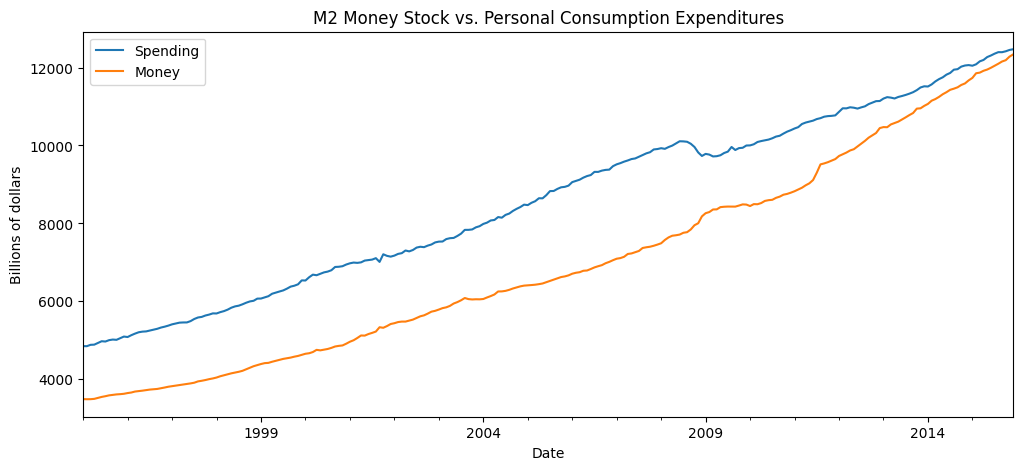

In [10]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel= 'Billions of dollars'
xlabel= ''

ax = df['Spending'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Money'].plot(legend=True);

#### the test for stationarity was done on both Money as well as the Spending feature. Order 2 difference makes the data stationary. 

#### Decide the order of the VARMA(p,q)


In [11]:
auto_arima(df['Money'],maxiter=100)

ARIMA(maxiter=100, order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [12]:
auto_arima(df['Spending'],maxiter=100)

ARIMA(maxiter=100, order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

In [13]:
# auto_arima(df['Spending'], maxiter=100) function is used to automatically determine the optimal ARIMA model for the df['Spending'] time series by iterating up to 
#100 times and evaluating different model configurations.

#### Order (1,2) is preferred for VARMA. 



In [14]:
df_transformed = df.diff().diff() # 2nd order difference

In [15]:
df_transformed = df_transformed.dropna() # remove the NaNs introduced due to differencing
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


#### Differencing introduces NaN values at the beginning of the series. For a second-order difference, two NaN values will be created (the first two rows will not have enough previous data to compute the difference).
The dropna() method removes these NaN values, ensuring that the resulting DataFrame is clean and ready for further analysis or modeling.

In [16]:
len(df_transformed)

250

#### Train Test Split


In [17]:
nobs = 12 # The last 12 months will be the test data. At least 1 year would be a good choice
train = df_transformed[0:-nobs]
test = df_transformed[-nobs:]

#### 0 indicates the starting index (the first row).
-nobs indicates the ending index, which is the position of the last nobs rows. For example, if nobs is set to 12, this means the last 12 rows will be excluded from the training set.

#### Fit the VARMA(1,2) Model


In [18]:
model = VARMAX(train, order=(1,2), trend='c') # c indicates a constant trend
results = model.fit(maxiter=1000, disp=False)
results.summary()

C:\Users\Lenovo\anaconda3\envs\aiml\lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.552
,+ intercept,AIC,4607.105
Date:,"Fri, 19 Jul 2024",BIC,4666.133
Time:,12:47:35,HQIC,4630.894
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.89, 0.01",Jarque-Bera (JB):,"536.06, 120.63"
Prob(Q):,"0.35, 0.92",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.57, 2.89",Skew:,"1.32, -0.33"


#### Predict the next 12 values


In [19]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-10.874268,35.057566
2015-02-01,-11.037186,-3.186138
2015-03-01,1.134477,-0.458673
2015-04-01,-1.519906,-0.109679
2015-05-01,1.019067,0.057316
2015-06-01,-0.369405,0.026582
2015-07-01,0.515734,0.058996
2015-08-01,-0.021907,0.041635
2015-09-01,0.309494,0.052780
2015-10-01,0.106140,0.046024


#### Invert the Transformations


#### The data used for prediction was of 2nd order difference. The forecast would also be similar and hence it needs to be inverted to retrieve the true values which we can compare the original Money and Spending in the last 12 months dataframe.

To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values. When working with second-order differences we first must perform this operation on the most recent first-order difference.

Here we'll use the nobs variable we defined during the train/test/split step.

In [20]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()
# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

In [21]:
df_forecast

,Money,Spending,Money1d,MoneyForecast
2015-01-01,-10.874268,35.057566,67.725732,11659.225732
2015-02-01,-11.037186,-3.186138,56.688546,11648.188546
2015-03-01,1.134477,-0.458673,57.823023,11649.323023
2015-04-01,-1.519906,-0.109679,56.303117,11647.803117
2015-05-01,1.019067,0.057316,57.322184,11648.822184
2015-06-01,-0.369405,0.026582,56.952779,11648.452779
2015-07-01,0.515734,0.058996,57.468512,11648.968512
2015-08-01,-0.021907,0.041635,57.446606,11648.946606
2015-09-01,0.309494,0.052780,57.756099,11649.256099
2015-10-01,0.106140,0.046024,57.862239,11649.362239


In [22]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [23]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-10.874268,35.057566,67.725732,11659.225732,45.657566,12097.057566
2015-02-01,-11.037186,-3.186138,56.688546,11648.188546,42.471429,12093.871429
2015-03-01,1.134477,-0.458673,57.823023,11649.323023,42.012756,12093.412756
2015-04-01,-1.519906,-0.109679,56.303117,11647.803117,41.903077,12093.303077
2015-05-01,1.019067,0.057316,57.322184,11648.822184,41.960393,12093.360393
2015-06-01,-0.369405,0.026582,56.952779,11648.452779,41.986975,12093.386975
2015-07-01,0.515734,0.058996,57.468512,11648.968512,42.045971,12093.445971
2015-08-01,-0.021907,0.041635,57.446606,11648.946606,42.087606,12093.487606
2015-09-01,0.309494,0.052780,57.756099,11649.256099,42.140386,12093.540386
2015-10-01,0.106140,0.046024,57.862239,11649.362239,42.186410,12093.586410


In [24]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
2015-01-01,11733.2,12046.0,11659.225732,12097.057566
2015-02-01,11852.4,12082.4,11648.188546,12093.871429
2015-03-01,11868.8,12158.3,11649.323023,12093.412756
2015-04-01,11916.1,12193.8,11647.803117,12093.303077
2015-05-01,11947.6,12268.1,11648.822184,12093.360393
2015-06-01,11993.1,12308.3,11648.452779,12093.386975
2015-07-01,12045.3,12355.4,11648.968512,12093.445971
2015-08-01,12096.8,12394.0,11648.946606,12093.487606
2015-09-01,12153.8,12392.8,11649.256099,12093.540386
2015-10-01,12187.7,12416.1,11649.362239,12093.586410
